In [1]:
import networkx as nx
import numpy as np
import random as rd
import matplotlib.pyplot as plt

from utils_simplagion_MC import *


In [15]:
def find_k2_k3(G):
    
    node_neighbors_dict = {}
    for n in G.nodes():
        node_neighbors_dict[n] = G[n].keys()

    triangles_list = set()
    triangles = [clique for clique in nx.enumerate_all_cliques(G) if len(clique) == 3]
    for triangle in triangles:
        triangles_list.add(tuple(sorted(triangle)))
    triangles_list = [list(tri) for tri in triangles_list]

    return node_neighbors_dict, triangles_list

def import_connectome(connectome_path):
    adj_matrix = np.loadtxt(connectome_path, delimiter=',', dtype=float)

    roi_no_to_delete = [81, 80, 35, 34]

    for roi_no in roi_no_to_delete:
        adj_matrix = np.delete(adj_matrix, roi_no, axis=0)
        adj_matrix = np.delete(adj_matrix, roi_no, axis=1)

    G = nx.from_numpy_array(adj_matrix)
    node_neighbors_dict, triangles_list = find_k2_k3(G)

    N = len(node_neighbors_dict.keys())
    avg_k1 = 1.*sum([len(v) for v in node_neighbors_dict.values()])/N
    avg_k2 = 3.*len(triangles_list)/N

    return node_neighbors_dict, triangles_list, avg_k1, avg_k2

In [31]:
def markovChain(beta, beta_D, mu, node_neighbors_dict, tri_neighbors_dict, NSteps, i0, AB_lvl_path):
    N = len(node_neighbors_dict)
    p = np.loadtxt(AB_lvl_path, delimiter=',', dtype=float)
    p_new = np.copy(p)
    
    q = 1
    pTime = [np.mean(p)]
    for k in range(0,NSteps):
        for i in range(0,N):
            
            #Updating the q_i (infections) - d=1
            for j in node_neighbors_dict[i]:
                q *= (1.-beta*p[j])
                
            #Updating the q_i (infections) - d=2
            for j, k in tri_neighbors_dict[i]:
                q *= (1.-beta_D*p[j]*p[k])
            
            #Updating the vector
            p_new[i] = (1-q)*(1-p[i]) + (1.-mu)*p[i]
            
            #Resetting the i-th parameters
            q = 1
            
        p = np.copy(p_new)
        pTime.append(np.mean(p))

    return np.mean(pTime[int(NSteps*0.8):]), p

In [32]:
data_dir = 'Data/AD/sub-AD4009/'
connect_matrix_filename = 'connect_matrix_norm.csv'
AB_lvl_filename = 'sub-AD4009_ses-baseline_acq-AP_date-2011-07-07_trc-av45_pet.csv'

node_neighbors_dict, triangles_list, avg_k1, avg_k2 = import_connectome(data_dir + connect_matrix_filename)
tri_neighbors_dict = get_tri_neighbors_dict(triangles_list)

mu = 0.05
lambda1s = np.linspace(0.0001,1.5,20)
lambdaD_target_list = [2.5,2.5,0]
I_percentage_list = [40,1,1]

betas = 1.*(mu/avg_k1)*lambda1s

NSteps = 500

In [33]:
markov_results = []

for lambdaD_target, I_percentage in zip(lambdaD_target_list, I_percentage_list):
    beta_D = 1.*(mu/avg_k2)*lambdaD_target
    i0 = I_percentage/100.
    for beta in betas:
        rho_markov, p = markovChain(beta, beta_D, mu, node_neighbors_dict, tri_neighbors_dict, NSteps, i0, data_dir+AB_lvl_filename)
    np.savetxt(data_dir+'AB_lvls_lambdaD_'+str(lambdaD_target)+'_I_percentage_'+str(I_percentage)+'.csv', p.reshape(1, -1), delimiter=',', fmt='%.16f')
    markov_results.append(rho_markov)

KeyboardInterrupt: 

/var/folders/cd/rgg857vd6xggr1p8_8d98kzr0000gn/T/ipykernel_71378/729815391.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(lambda1s, rho, '-o', color=linecolor[j], lw=1.5, marker=markers[j],


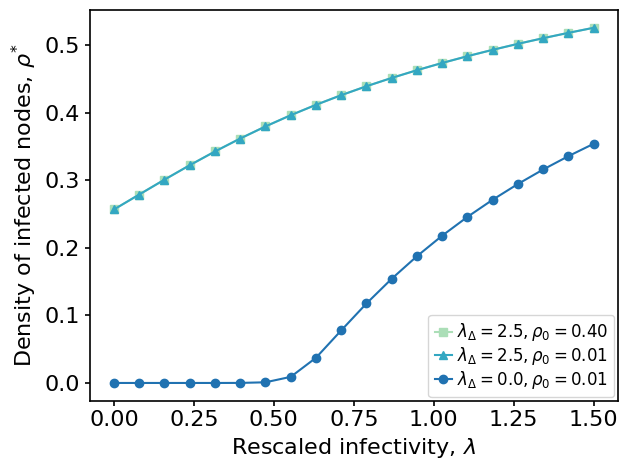

In [13]:
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2

markers = ['s', '^', 'o']
linecolor = [plt.cm.YlGnBu(0.3), plt.cm.YlGnBu(0.55), plt.cm.YlGnBu(0.7)]

ax = plt.subplot(111)

for j, rho in enumerate(markov_results):
    ax.plot(lambda1s, rho, '-o', color=linecolor[j], lw=1.5, marker=markers[j],
            label=r'$\lambda_\Delta=%.1f, \rho_0=%.2f$'%(lambdaD_target_list[j], 0.01*I_percentage_list[j]))
        
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'Rescaled infectivity, $\lambda$', size=16)
ax.set_ylabel(r'Density of infected nodes, $\rho^{*}$', size=16)
ax.legend(fontsize=12, handlelength=1, handletextpad=0.3, labelspacing=0.1, borderaxespad=0.2, loc=4)  

plt.tight_layout()